<a href="https://colab.research.google.com/github/Cod-lang/Face_similarity_with-siamese_in_Pytorch/blob/main/ATandTimages_using%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import PIL.ImageOps  
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
import os
import sys

In [4]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy() # channel, hight, width = (0, 1, 2)
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (1, 2, 0) = channel last notation
    plt.show()   

In [5]:
 def show_plot(iteration,loss):
    plt.plot(iteration, loss)
    plt.show()

### Configuration class

In [6]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"

    train_batch_size = 64
    train_number_epochs = 500

### Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [7]:
class SiameseNetworkDataset(Dataset):
    
    # this is invoked when the object is created
    def __init__(self, imageFolderDataset, transform=None, should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert

    # this is invoked when you loop through the datasets / iterating    
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #27
        #print("anchor image ", img0_tuple)
        
        #we need to make sure approx 50% of images are in the same class        
        should_get_same_class = random.randint(0, 1) # 0 => genuine, 1 = imposter
        
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) #27                
                if img0_tuple[1]==img1_tuple[1]:
                    #print("Positive Image : 0 ", img1_tuple) 
                    break
        else:
            while True:
                #keep looping till a different class image is found                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    #print("Negative Image : 1 ", img1_tuple) 
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img1_cls = img1_tuple[0].split('/')[-2]

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        label = torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
        
        # img0, img1, label 0 (genuine) / 1 (imposter)
        return img0, img1 , label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

#### Using Image Folder Dataset

In [8]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [9]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

### Visualising the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.

In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


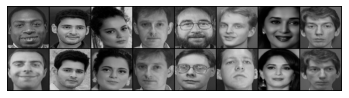

[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [12]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())                        # 1 -> means dissimilar(persons/not from same subject-folders) and 0 -> means similar

## Neural Net Definition
We will use a standard convolutional neural network

In [13]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),  #padding
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),                                   
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),                                       


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),  

            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),          
                                                     
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 256) 
            ) 

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)                                      # flattening
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def imgfeature(self,inp):
        # to get the representations of train and test
        fet = self.forward_once(inp)
        return fet

In [14]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

#### Training the network

In [15]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,                                                                  # shuffle = False will make it sequential
                        num_workers=4,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [17]:
counter = []
loss_history = [] 
iteration_number= 0

### Training

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch number 0
 Current loss 1.025335669517517

Epoch number 1
 Current loss 197.8914031982422

Epoch number 2
 Current loss 8.272197723388672

Epoch number 3
 Current loss 8.026718139648438

Epoch number 4
 Current loss 4.1913347244262695

Epoch number 5
 Current loss 2.5216519832611084

Epoch number 6
 Current loss 1.4062886238098145

Epoch number 7
 Current loss 8.117631912231445

Epoch number 8
 Current loss 0.7641690969467163

Epoch number 9
 Current loss 0.4096178412437439

Epoch number 10
 Current loss 0.3613787889480591

Epoch number 11
 Current loss 0.32559219002723694

Epoch number 12
 Current loss 0.317893922328949

Epoch number 13
 Current loss 0.21212147176265717

Epoch number 14
 Current loss 0.24141624569892883

Epoch number 15
 Current loss 0.22416198253631592

Epoch number 16
 Current loss 0.21972443163394928

Epoch number 17
 Current loss 0.25355327129364014

Epoch number 18
 Current loss 0.1962200105190277

Epoch number 19
 Current loss 0.13408392667770386

Epoch num

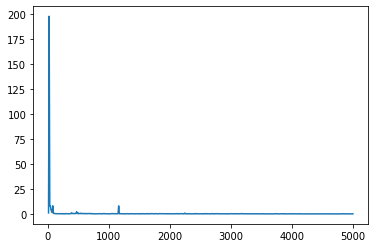

In [18]:
#training
for epoch in range(0,Config.train_number_epochs):

    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()

        optimizer.zero_grad()
        output1,output2 = net(img0,img1)                           #forward method is invoked            
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

### Testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [19]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

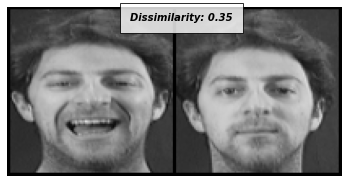

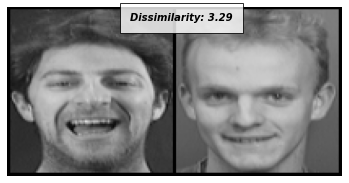

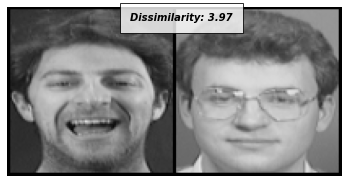

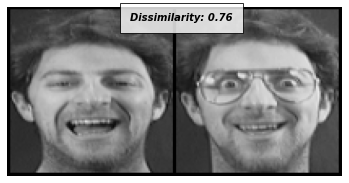

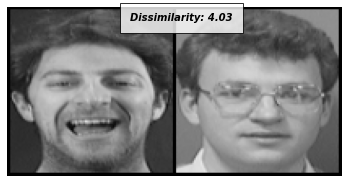

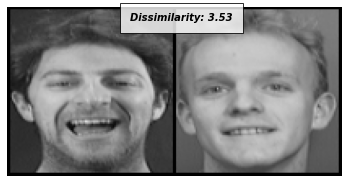

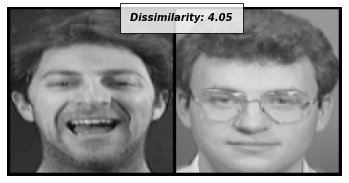

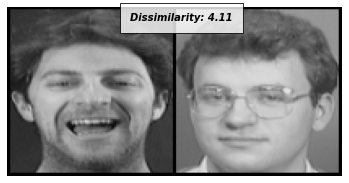

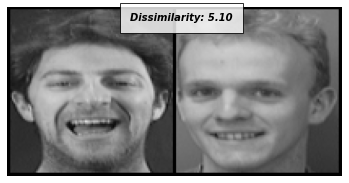

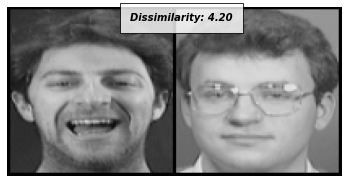

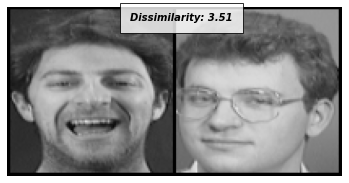

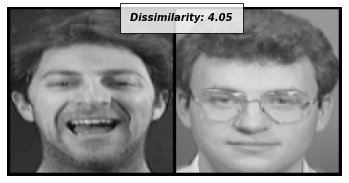

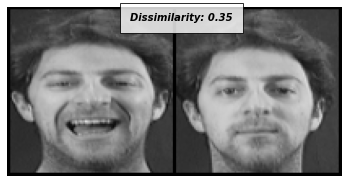

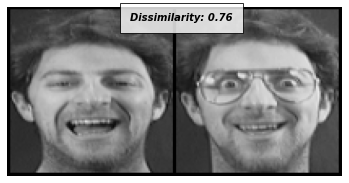

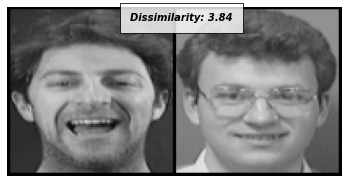

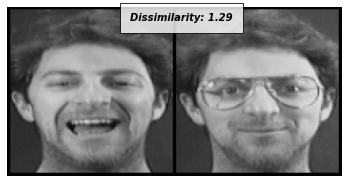

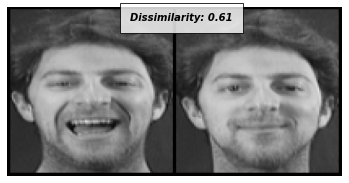

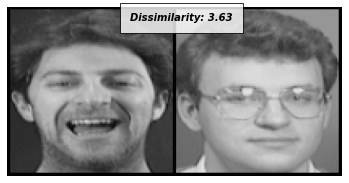

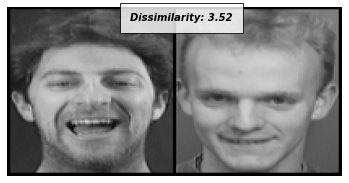

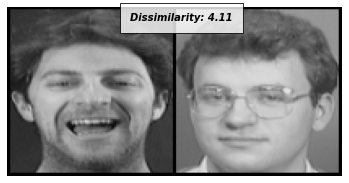

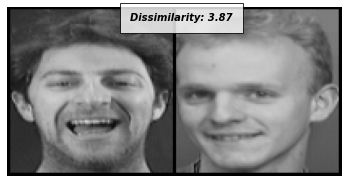

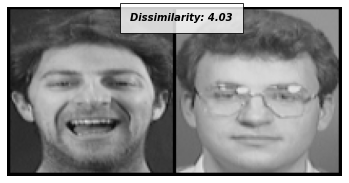

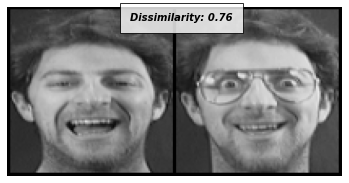

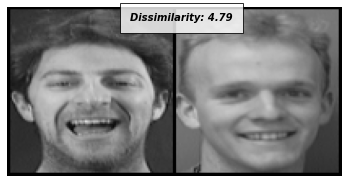

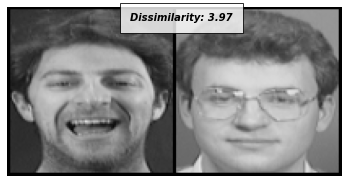

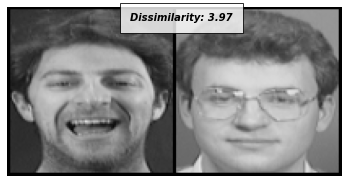

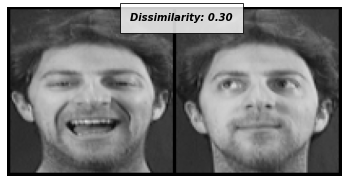

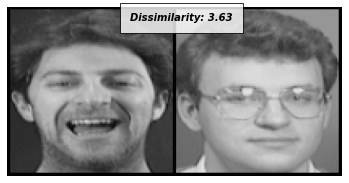

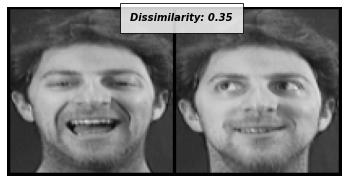

In [20]:

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=2,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
# Visualising the dissimilarity measures for pairs of images in the test-folder 
for i in range(29):
    _, x1, label2= next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2) #similarity metric
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))


## **Saving the Neural network model**

In [21]:
torch.save(net.state_dict(),'get_class.pth') 

### **Extracting the fetaures of every image by applying the model. And Saving those features**

In [22]:
img_file_list=[]
img_file_list = [x for x in folder_dataset.imgs]                   # folder_dataset contains training image folders
for x in folder_dataset_test.imgs:                                   # folder_dataset_test contains testing image folders
  img_file_list.append(x) 
  
transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])

feat = []                     
img_cls = []
path_img = []

for y in img_file_list:                                                                                    
    check_img  =  Image.open(y[0]) 
    ch_img = check_img.convert("L")  
    ch_img = transform(ch_img)      
    ch_img_us =torch.unsqueeze(ch_img,0)
    output = net.imgfeature(Variable(ch_img_us).cuda())  # applying the nn model to get the features of images

    ch_img_features = output.cpu().detach().numpy()
    feat.append(ch_img_features)
    img_cls.append(y[0].split('/')[-2] )       # list containig the class of image
    path_img.append(y[0])                                 # list containing image file path
    

## **Get the representations of all the training and testing images** 

In [23]:
feat_arr =  np.asarray(feat)
# reshaping array 3d to 2d
feat_arr = np.reshape(feat,(-1,256))
image_data = pd.DataFrame(feat_arr)
image_data['class'] = img_cls                         # dataframe with training images' features
image_data['Path_of_images'] = path_img   # path of images column has been included for vidualisation purposes during analysis


In [27]:
# Visualising last three rows of image-feature data-set
image_data.tail(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,class,Path_of_images
480,0.038838,0.193222,-0.091528,0.469938,-0.311922,0.116149,0.029599,-0.066071,0.003065,-0.715237,-0.048953,-0.002713,0.068781,0.146929,-0.012231,0.081355,-0.025763,-0.106457,0.175931,0.023294,0.065229,-0.073648,0.013335,0.374097,-0.124914,-0.084232,-0.240656,0.018615,-0.071439,0.251477,-0.152872,-0.056780,-0.001447,-0.102434,-0.069026,-0.146309,-0.001537,0.082276,0.193828,-0.155368,...,0.103578,0.072812,0.416950,-0.064725,0.004147,0.071089,0.129155,0.050269,-0.011748,0.118647,0.170684,0.180387,0.147482,-0.077553,0.071387,-0.134422,0.068262,0.557126,0.202982,-0.035066,-0.157167,0.205691,-0.133695,-0.099761,0.078028,-0.537685,-0.097438,-0.049352,-0.034216,-0.189653,0.111059,0.323683,-0.133224,-0.048268,0.006102,-0.005064,0.001646,-0.008020,s7,./data/faces/testing/s7/5.pgm
481,0.022125,0.357459,-0.078053,0.690180,-0.524826,0.117392,0.029625,-0.052447,-0.000415,-1.058563,-0.051919,-0.008608,0.097662,0.126457,-0.017916,0.300956,-0.025255,-0.095654,0.166407,0.020603,0.089918,-0.065780,0.017048,0.538804,-0.175929,-0.075020,-0.219814,0.015492,-0.064456,0.208708,-0.148068,-0.045571,0.001782,-0.089802,-0.067461,-0.135123,-0.001695,0.075931,0.270303,-0.114896,...,0.076755,0.072899,0.543915,-0.059739,0.060737,0.059896,0.116448,0.046291,-0.099632,0.091821,0.150996,0.159221,0.126007,-0.072300,0.066788,-0.106389,0.066410,0.799212,0.184903,-0.020581,-0.245236,0.176972,-0.118314,-0.084417,0.167596,-0.703684,-0.083849,-0.041442,-0.095573,-0.164330,0.097230,0.493261,-0.132092,-0.029293,0.119199,-0.033490,-0.081604,-0.006842,s7,./data/faces/testing/s7/6.pgm
482,0.051313,0.295601,-0.110545,0.656982,-0.463855,0.137577,0.031982,-0.060173,0.003859,-1.019792,-0.052321,0.001198,0.087951,0.179156,-0.010406,0.194467,-0.034298,-0.118022,0.212519,0.025486,0.090151,-0.086302,0.009172,0.535085,-0.112054,-0.094394,-0.278514,0.022231,-0.074674,0.199785,-0.178615,-0.063481,-0.013767,-0.121656,-0.089293,-0.170075,0.000448,0.093226,0.182960,-0.171988,...,0.137375,0.094628,0.308392,-0.072394,0.020576,0.082900,0.157763,0.057408,-0.043266,0.140391,0.197231,0.223352,0.173851,-0.095427,0.090811,-0.155023,0.080152,0.792034,0.236580,-0.050384,-0.211623,0.241853,-0.164240,-0.112894,0.147732,-0.582943,-0.113539,-0.057697,-0.071438,-0.214299,0.130135,0.333018,-0.152758,-0.051670,0.053806,-0.026872,-0.057633,-0.018188,s7,./data/faces/testing/s7/7.pgm
483,0.034770,0.292474,-0.090483,0.617778,-0.446973,0.122913,0.030460,-0.055943,0.001892,-0.950531,-0.050830,-0.004018,0.085686,0.146396,-0.014002,0.209973,-0.028004,-0.104614,0.181788,0.022918,0.084349,-0.073074,0.013513,0.490917,-0.133279,-0.083057,-0.241296,0.018597,-0.068971,0.201624,-0.157774,-0.053757,-0.003849,-0.102048,-0.074751,-0.147721,-0.001037,0.082834,0.210478,-0.141897,...,0.102885,0.079187,0.401398,-0.064650,0.033445,0.069647,0.131661,0.050258,-0.058242,0.112366,0.169374,0.182726,0.144294,-0.080356,0.074593,-0.127565,0.071101,0.728657,0.203735,-0.033045,-0.209590,0.201936,-0.135047,-0.096667,0.138813,-0.598182,-0.095517,-0.048691,-0.070722,-0.184690,0.109766,0.378281,-0.137754,-0.041341,0.069967,-0.024693,-0.054849,-0.010528,s7,./data/faces/testing/s7/8.pgm
484,0.034394,0.303618,-0.090426,0.635004,-0.462571,0.123903,0.030626,-0.054102,0.001812,-0.978363,-0.050959,-0.004067,0.087352,0.146489,-0.014113,0.224933,-0.028345,-0.104433,0.182707,0.022953,0.086996,-0.072948,0.013412,0.504769,-0.131105,-0.083036,-0.241499,0.018726,-0.068652,0.191125,-0.158489,-0.053506,-0.004328,-0.102129,-0.075765,-0.148007,-0.000961,0.083078,0.208234,-0.140520,...,0.103593,0.080142,0.387157,-0.064707,0.036687,0.069654,0.132225,0.050252,-0.063247,0.111738,0.169461,0.183276,0.143885,-0.080857,0.075061,-0.126943,0.071610,0.749069,0.203937,-0.032991,-0.21528

### **Saving the feature representations along with corresponding class-labels into a csv file**

In [25]:
# saving the dataframe with the class column to a (different)csv file
image_data.to_csv('Features_with_class.csv', index=False)